In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# RETE NEURALE per riconoscimento cartelli stradali

*  Importazoine del dataset
*  Costruzione del modello
*  Training del modello 
*  Valutazione del modello

## Convolutional Neural Network

![alt text](https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg) 

Le reti convoluzionali (CNN) sono reti neurali artificiali profonde che vengono utilizzate per molte applicazioni.

Una CNN è una sequenza di livelli e ogni livello di una CNN trasforma un volume di attivazioni in un altro attraverso una funzione differenziabile. <br>
Per creare architetture CNN vengono utilizzati tre tipi principali di livelli: livello convoluzionale, livello di pooling e livello fully connected; questi livelli sono impilati per formare un'architettura CNN completa.

**Apprendimento delle funzioni**
1. Convoluzione: applica dei filtri con dei pesi per generare feature maps.<br>
2. Non linearità: spesso ReLU, sigmoide o tanh.<br>
3. Pooling: operazione di downsampling su ciascuna feature maps.<br>
 
La classificazone finale si ottiene definendo gli ultimi strati:

**Classificazione**
1. Flatten: converti l'output della parte Feature Learning della CNN in un vettore di funzionalità 1D.<br>
2. Fully connected: utilizza le funzionalità estratte dai livelli precedenti per classificare l'input.<br>
3. Softmax: output espresso come probabilità di dati di input appartenenti a una particolare classe.<br>

---
## **LIBRERIE e directory**

installiamo tensor flow e le librerie

In [ ]:
!pip install tensorflow_hub

from PIL import Image
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd 
from sklearn.metrics import accuracy_score
# nvida tool to check the GPU
#!nvidia-smi

    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',

TensorFlow è una piattaforma open source end-to-end per l'apprendimento automatico

#####configurazione dell'output

In [ ]:
OUTPUT_ROOT_DIR = "output/"
OUTPUT_TFLITE_MODEL = os.path.join(OUTPUT_ROOT_DIR, "retrained_graph_mv1_100_224.tflite")
OUTPUT_LABELS = os.path.join(OUTPUT_ROOT_DIR, "retrained_labels_mv1_100_224.txt")
OUTPUT_READABLE_LABELS = os.path.join(OUTPUT_ROOT_DIR, "labels_readable.txt")

#####configurazione modello

In [ ]:
#SELECTED_MOBILENET = ""https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/4"

IMAGE_SHAPE = (224, 224)

MODEL_INPUT_HEIGHT = 224
MODEL_INPUT_WIDTH = 224
MODEL_INPUT_MEAN = 0
MODEL_INPUT_STD = 255

#Input layer of MobileNet v1 has constant name called "Placeholder"
MODEL_INPUT_LAYER_NAME = "Placeholder"
#Output layer can be defined by us, default one is "final_result"
MODEL_OUTPUT_LAYER_NAME = "final_result"

## **Dataset**


In [ ]:
TMP_DATA_DIR = "dataset/tmp"
TMP_LABELS_DIR = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test")

TRAINING_DATA_DIR = "dataset/training"
VALIDATION_DATA_DIR = "dataset/validation"

##### Recupera le immagini dal sito Web di GTSRB

In [ ]:

#Immagini per training
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
#Immagini per validation    
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
#Etichette per validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

** Resuming transfer from byte position 276294756
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
curl: (33) HTTP server doesn't seem to support byte ranges. Cannot resume.
** Resuming transfer from byte position 88978620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (33) HTTP server doesn't seem to support byte ranges. Cannot resume.
** Resuming transfer from byte position 99620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:-- 

#####Un-zipping dei dati

In [ ]:
%%time
to_unpack = [
    ("GTSRB_Final_Training_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_GT.zip", TMP_LABELS_DIR)
]
 
for file, directory in to_unpack:
    print("Unzipping {} to {}...".format(file, directory))
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(directory)

Unzipping GTSRB_Final_Training_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_GT.zip to dataset/tmp/GTSRB/Final_Test...
CPU times: user 14.8 s, sys: 7.65 s, total: 22.5 s
Wall time: 29.4 s


#####Lable (etichette delle categorie)

In [ ]:
label_map = {
    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

if not os.path.exists(OUTPUT_ROOT_DIR):
        os.makedirs(OUTPUT_ROOT_DIR)

file = open(OUTPUT_READABLE_LABELS, 'w')
for key, val in sorted(label_map.items()):
    file.write("{}\n".format(val))
file.close()

#### Preparazione Training dataset

Dobbiamo convertire le nostre immagini del database in formato .jpg per elaborarle con TensorFlow

In [ ]:
# Raccogli tutti i file PPM e le relative etichette

tmp_train_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Training/Images")

# Ottieni tutte le sottodirectory di data_dir. Ciascuno rappresenta un'etichetta
directories = [d for d in os.listdir(tmp_train_data_dir) 
               if os.path.isdir(os.path.join(tmp_train_data_dir, d))]
# Scorri le directory delle etichette e raccogli i dati in due elenchi, etichette e immagini.
ppm_files_train = []
ppm_labels_train = []
for class_directory in directories:
    label_dir = os.path.join(tmp_train_data_dir, class_directory)
    file_names = [os.path.join(label_dir, f) 
                  for f in os.listdir(label_dir) if f.endswith(".ppm")]
    # Per ogni etichetta, carica le sue immagini e aggiungile alla lista delle immagini.
    # E aggiungi il numero dell'etichetta (cioè il nome della directory) alla lista delle etichette.
    for image_file in file_names:
        ppm_files_train.append(image_file)
        ppm_labels_train.append(class_directory)
        
# riordino per una migliore lettura
ppm_files_train.sort()
ppm_labels_train.sort()

In [ ]:
%%time
# Converto
# from: dataset/Final_Training/Images/00000/00000_00000.ppm
# to:   dataset/training/00000/00000_00000.jpg

for ppm_file, label in zip(ppm_files_train, ppm_labels_train):
    image = Image.open(ppm_file)
    directory = os.path.join(TRAINING_DATA_DIR, label)
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    image.save(os.path.join(directory, image_filename))

CPU times: user 14.1 s, sys: 5.52 s, total: 19.6 s
Wall time: 20.9 s


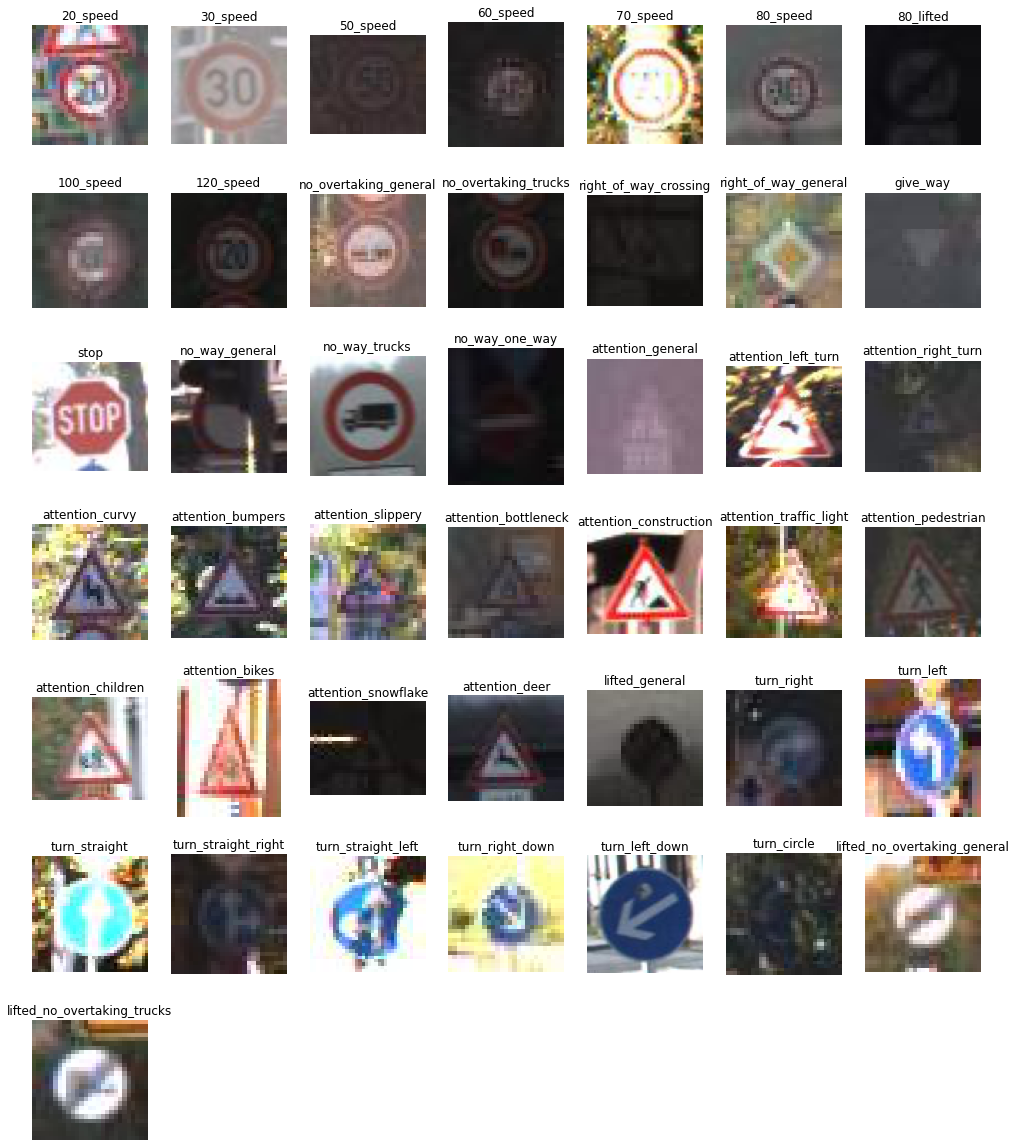

In [ ]:
# Stampa tutte le categorie con un'immagine di esempio per ciascuna di esse
preprocessed_training_dirs = [d for d in os.listdir(TRAINING_DATA_DIR) 
               if os.path.isdir(os.path.join(TRAINING_DATA_DIR, d))]
preprocessed_training_dirs.sort()

training_images = []
for training_dir in preprocessed_training_dirs:
    training_images.append(os.path.join(TRAINING_DATA_DIR, training_dir, "00000_00000.jpg"))

i = 0
plt.figure(figsize=(17, 30))
for image in training_images:
    plt.subplot(10,7, i + 1)
    plt.axis('off')
    plt.title("{}".format(label_map[i]))
    i += 1
    plt.imshow(Image.open(image))
plt.show()

Tutti i moduli immagine di TensorFlow Hub prevedono input float nell'intervallo [0, 1]. Utilizziamo il parametro di `rescale` di `ImageDataGenerator`'s  per ottenere questo risultato.

La dimensione dell'immagine verrà gestita in seguito.

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(TRAINING_DATA_DIR), target_size=IMAGE_SHAPE)

Found 39209 images belonging to 43 classes.


L'oggetto risultante è un iteratore (for) che restituisce coppie image_batch, label_batch.

In [ ]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 43)


#### Preparazione del dataset di convalida

Converto anche il dataset di convalida da *.ppm a *.jpg


In [ ]:
#Carico il mio testing set
tmp_validation_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test/Images")

In [ ]:
%%time

tmp_validation_data_files = [f for f in os.listdir(tmp_validation_data_dir) if f.endswith(".ppm")]
validation_images = []

#export as JPGs
for ppm_file in tmp_validation_data_files:
    image_dir = os.path.join(tmp_validation_data_dir, ppm_file) 
    image = Image.open(image_dir)
    directory = VALIDATION_DATA_DIR
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
        
    final_image = os.path.join(directory, image_filename)
    image.save(final_image)

    validation_images.append(final_image)
    validation_images.sort()
    
print("Validation images count:", len(validation_images))

Validation images count: 12630
CPU times: user 6.53 s, sys: 1.72 s, total: 8.25 s
Wall time: 8.33 s


##**Creazione modello**

Carichiamo un modello già impostato dall'hub di TensorFlow per <br> essere sicuri di avere un modello affidabile e funzionante.




> L'output è un batch di feature vectors. Per ogni immagine di input, il feature vector ha dimensione num_features = 1024. I feature vectors possono quindi essere utilizzati ulteriormente, ad esempio, per la classificazione.

> Le immagini in input hanno dimensione altezza x larghezza = 224 x 224 pixel per impostazione predefinita.





In [ ]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))

feature_batch = feature_extractor_layer(image_batch)

print(feature_batch.shape)

(32, 1280)


Blocca le variabili nel livello di estrazione funzionalità, in modo che l'addestramento modifichi solo il nuovo livello di classificazione.

In [ ]:
feature_extractor_layer.trainable = False

Alleghiamo una lista di classificazione basata sul numero delle classi

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 43])

###Questo è il nostro **modello CNN**

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 43)                55083     
                                                                 
Total params: 2,313,067
Trainable params: 55,083
Non-trainable params: 2,257,984
_________________________________________________________________


## **Training**

**Metodi di learning rate adattativo** <br>
Risulta evidente quanto una opportuna regolazione del learning rate possa avere una forte influenza. A tal riguardo sono stati proposti diversi meccanismi adattativi per una regolazione automatica del learning rate

adaptive_learning_rate
Un importante miglioramento all'algoritmo della discesa del gradiente stocastico, che implementa una regolazione dinamica del learning rate basandosi sui valori storici del gradiente. <br>

La differenza tra adaptive_learning_rate e la classica discesa del gradiente risiede nel fatto che, durante il processo di aggiornamento di θ (teta), il learning rate non sarà più costante ma sarà continuamente ricalcolato utilizzando i valori storici del gradiente accumulati fino alla corrente iterazione. <br>

Il **metodo Adam** (Adaptive momentum estimation) introduce un ulteriore migliorament. Oltre a memorizzare la media mobile esponenziale dei quadrati dei gradienti delle precedenti iterazioni, viene memorizzata anche la media mobile esponenziale dei gradienti. Il nome dell'algoritmo deriva dal fatto che, ad ogni iterazione, mt e vt corrispondono al momento primo (la media) ed al momento secondo (la varianza) del gradiente.

### Start processo di training 
utilizzare compile per configurare il training process:

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

Start training

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
batch_stats_callback = CollectBatchStats()
 
history = model.fit(image_data, epochs=25, steps_per_epoch=steps_per_epoch, callbacks=[batch_stats_callback])

Epoch 1/25
1226/1226 [==============================] - 106s 86ms/step - loss: 0.4438 - acc: 0.9062
Epoch 2/25
1226/1226 [==============================] - 104s 84ms/step - loss: 0.2023 - acc: 0.9375
Epoch 3/25
1226/1226 [==============================] - 104s 85ms/step - loss: 0.6847 - acc: 0.7812
Epoch 4/25
1226/1226 [==============================] - 104s 84ms/step - loss: 0.0998 - acc: 1.0000
Epoch 5/25
1226/1226 [==============================] - 104s 84ms/step - loss: 0.5421 - acc: 0.9062
Epoch 6/25
1226/1226 [==============================] - 103s 84ms/step - loss: 0.1707 - acc: 1.0000
Epoch 7/25
1226/1226 [==============================] - 103s 84ms/step - loss: 0.3595 - acc: 0.8438
Epoch 8/25
1226/1226 [==============================] - 103s 84ms/step - loss: 0.3480 - acc: 0.9062
Epoch 9/25
1226/1226 [==============================] - 103s 84ms/step - loss: 0.2836 - acc: 0.9062
Epoch 10/25
1226/1226 [==============================] - 103s 84ms/step - loss: 0.1470 - acc: 0.9688

Possiamo vedere come il modello sta facendo progressi

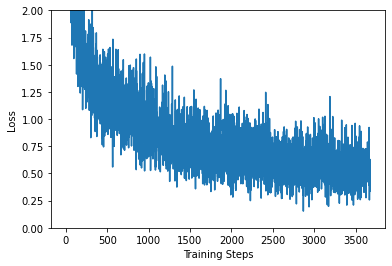

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

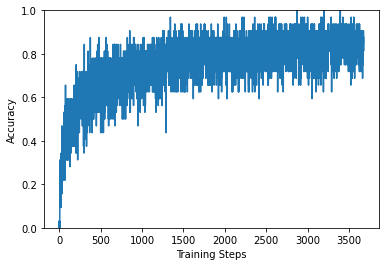

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

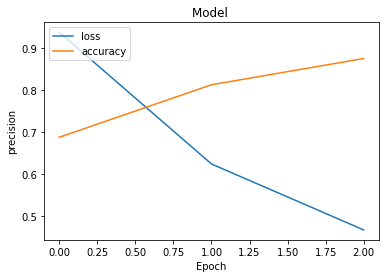

In [ ]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['loss'])
    plt.plot(history.history['acc'])
    plt.title('Model ')
    plt.ylabel('precision')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'accuracy'], loc='upper left')
    plt.show()


plot_history(history)

## **Valutazione del modello**



### Trasformazione del dataset di valutazione

Carica i dati di convalida dal file CSV in un frame di dati Panda. <br>
converto da *.ppm a *.jpg. <br>
Quindi ridimensionare anche i valori per il modello. ClassId deve essere una stringa e con zeri iniziali, poiché questa denominazione di classificazione è stata utilizzata anche per le sottocartelle nel set di dati di addestramento.

In [ ]:
tmp_validation_labels_csv = os.path.join(TMP_LABELS_DIR, "GT-final_test.csv")
val_data_frame = pd.read_csv(tmp_validation_labels_csv, header=0, sep=';')
val_data_frame['Filename'] = val_data_frame['Filename'].str.replace('.ppm','.jpg')
val_data_frame['ClassId'] = val_data_frame['ClassId'].astype(str).str.zfill(5)

image_val_data = image_generator.flow_from_dataframe(val_data_frame, x_col="Filename", directory=VALIDATION_DATA_DIR, y_col="ClassId", target_size=IMAGE_SHAPE)

Found 12630 validated image filenames belonging to 43 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for image_val_batch, label_val_batch in image_val_data:
  print("Image batch shape: ", image_val_batch.shape)
  print("Label batch shape: ", label_val_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 43)


### Ecco alcuni risultati
Eseguo un batch di immagini attraverso il modello ed estraggo l'ID del segnale stradale previsto.

In [ ]:
predicted_batch = model.predict(image_val_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_val_batch, axis=-1)

alcune immagini con il risultato della previsione.
Stampo la precisione per il batch visualizzato

Accuracy of the shown eval batch:


0.75

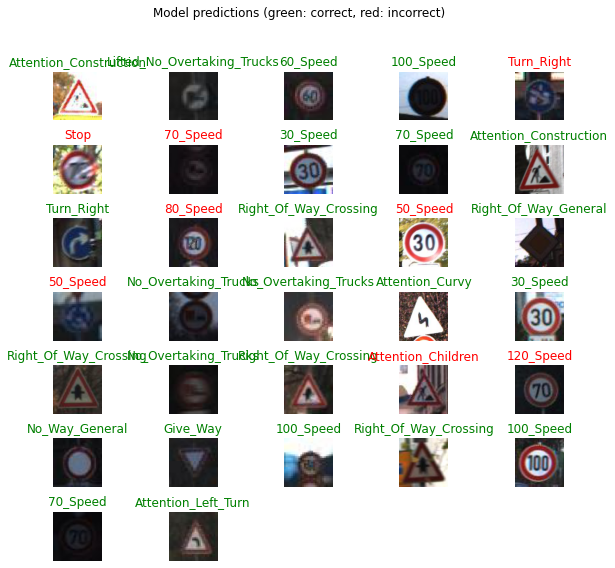

In [ ]:
batch_size = image_val_batch.shape[0]
num_plot_column = 5
num_plot_row = batch_size // num_plot_column + (batch_size % num_plot_column > 0)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(batch_size):
  plt.subplot(num_plot_row,num_plot_column,n+1)
  plt.imshow(image_val_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(label_map[predicted_id[n]].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

print("Accuracy of the shown eval batch:")
accuracy_score(label_id, predicted_id)

### Calcolare le metriche del set di dati di convalida 

Calcolare  l'accuratezza di precisione e la loss di tutte le immagini nel set di dati di convalida

In [ ]:
score = model.evaluate(x=image_val_data, batch_size=image_val_data.batch_size, steps=image_val_data.samples/image_val_data.batch_size)
print("Loss: ", score[0], "Accuracy: ", score[1])


394/394 [==============================] - 33s 82ms/step - loss: 1.1084 - acc: 0.6781
Loss:  1.1083595752716064 Accuracy:  0.6780681014060974


# RICONOSCIMENTO CARREGGIATA

L'obiettivo di questa parte di codice è quello di **creare una semplice pipeline per rilevare le linee stradali** in un fotogramma ripreso da una telecamera montata sul tetto. 
Una pipeline di dati racchiude una serie di azioni, che partono dall'acquisizione di tutti i dati grezzi provenienti da una sorgente per trasformarli rapidamente in dati pronti per essere analizzati.

##LINEE

In [ ]:
import numpy as np
import cv2


class Line:
    """
    A Line is defined from two points (x1, y1) and (x2, y2) as follows:
    y - y1 = (y2 - y1) / (x2 - x1) * (x - x1)
    Each line has its own slope and intercept (bias).
    """
    def __init__(self, x1, y1, x2, y2):

        self.x1 = np.float32(x1)
        self.y1 = np.float32(y1)
        self.x2 = np.float32(x2)
        self.y2 = np.float32(y2)

        self.slope = self.compute_slope()
        self.bias = self.compute_bias()

    def compute_slope(self):
        return (self.y2 - self.y1) / (self.x2 - self.x1 + np.finfo(float).eps)

    def compute_bias(self):
        return self.y1 - self.slope * self.x1

    def get_coords(self):
        return np.array([self.x1, self.y1, self.x2, self.y2])

    def set_coords(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def draw(self, img, color=[255, 0, 0], thickness=10):
        cv2.line(img, (self.x1, self.y1), (self.x2, self.y2), color, thickness)


##LANE DETECTION

In [ ]:
import os

# lane detection
def region_of_interest(img, vertices):

    """
    Applica una maschera immagine.
    Mantiene solo la regione dell'immagine definita dal poligono
    formato da `vertici`. Il resto dell'immagine è impostato su nero.

    Il rilevamento dei bordi di Canny è considerato un rilevamento dei bordi migliore
    (in senso di falso allarme)
    Ciò è dovuto principalmente a 2 passaggi:
    Soppressione non massima: i candidati ai bordi che non sono dominanti nel loro vicinato non sono
    considerati bordi.
    Processo di isteresi - Mentre ci si sposta lungo i candidati, dato un candidato che si trova nelle
    vicinanze di un bordo la soglia è più bassa.
    Questi 2 passaggi riducono il numero di spigoli "falsi" e quindi creano un punto di partenza
    migliore per un processo più lontano come la trasformazione di Hough.
    """

    # definire una maschera vuota con cui iniziare
    mask = np.zeros_like(img)
    # definire un colore a 3 canali o 1 canale con cui riempire la maschera a seconda dell'immagine in ingresso
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    # pixel di riempimento all'interno del poligono definito da "vertici" con il colore di riempimento
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # restituendo l'immagine solo dove i pixel della maschera sono diversi da zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image, mask


def hough_lines_detection(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` è l'output di una trasformazione di Canny.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    return lines


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    Restituisce l'immagine di fusione risultante calcolata come segue:
    initial_img * α + img * β + λ
    """

    img = np.uint8(img)
    if len(img.shape) is 2:
        img = np.dstack((img, np.zeros_like(img), np.zeros_like(img)))

    return cv2.addWeighted(initial_img, α, img, β, λ)


def compute_lane_from_candidates(line_candidates, img_shape):
    """
    Calcola linee che approssimano la posizione di entrambe le corsie stradali.

    :parametro line_candidates: le righe di hough si trasformano
    :parametro image_shape: forma dell'immagine a cui è stata applicata la trasformazione di hough
    :return: linee che approssimano la posizione della corsia sinistra e destra
    """

    # separare le linee candidate in base alla loro pendenza
    pos_lines = [l for l in line_candidates if l.slope > 0]
    neg_lines = [l for l in line_candidates if l.slope < 0]

    # interpolare le deviazioni e le pendenze per calcolare l'equazione della linea che approssima
    # la corsia di sinistra. la mediana viene utilizzata per filtrare i valori anomali
    neg_bias = np.median([l.bias for l in neg_lines]).astype(int)
    neg_slope = np.median([l.slope for l in neg_lines])
    x1, y1 = 0, neg_bias
    x2, y2 = -np.int32(np.round(neg_bias / neg_slope)), 0
    left_lane = Line(x1, y1, x2, y2)

    # interpola le deviazioni e le pendenze per calcolare l'equazione della linea che approssima
    # la mediana della corsia di destra viene utilizzata per filtrare i valori anomali
    lane_right_bias = np.median([l.bias for l in pos_lines]).astype(int)
    lane_right_slope = np.median([l.slope for l in pos_lines])
    x1, y1 = 0, lane_right_bias
    x2, y2 = np.int32(np.round((img_shape[0] - lane_right_bias) / lane_right_slope)), img_shape[0]
    right_lane = Line(x1, y1, x2, y2)

    return left_lane, right_lane


def get_lane_lines(color_image, solid_lines=True):
    """
    This function take as input a color road frame and tries to infer the lane lines in the image.
    :param color_image: input frame
    :param solid_lines: if True, only selected lane lines are returned. If False, all candidate lines are returned.
    :return: list of (candidate) lane lines.
    """
    # resize to 960 x 540
    color_image = cv2.resize(color_image, (960, 540))

    # convert to grayscale
    img_gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

    # perform gaussian blur
    img_blur = cv2.GaussianBlur(img_gray, (17, 17), 0)

    # perform edge detection
    img_edge = cv2.Canny(img_blur, threshold1=50, threshold2=80)

    # perform hough transform
    detected_lines = hough_lines_detection(img=img_edge,
                                           rho=2,
                                           theta=np.pi / 180,
                                           threshold=1,
                                           min_line_len=15,
                                           max_line_gap=5)

    # convert (x1, y1, x2, y2) tuples into Lines
    detected_lines = [Line(l[0][0], l[0][1], l[0][2], l[0][3]) for l in detected_lines]

    # if 'solid_lines' infer the two lane lines
    if solid_lines:
        candidate_lines = []
        for line in detected_lines:
                # consider only lines with slope between 30 and 60 degrees
                if 0.5 <= np.abs(line.slope) <= 2:
                    candidate_lines.append(line)
        # interpolate lines candidates to find both lanes
        lane_lines = compute_lane_from_candidates(candidate_lines, img_gray.shape)
    else:
        # if not solid_lines, just return the hough transform output
        lane_lines = detected_lines

    return lane_lines


def smoothen_over_time(lane_lines):
    
    #Smussa l'inferenza della linea di corsia su una finestra di frame e restituisce le linee medie

    avg_line_lt = np.zeros((len(lane_lines), 4))
    avg_line_rt = np.zeros((len(lane_lines), 4))

    for t in range(0, len(lane_lines)):
        avg_line_lt[t] += lane_lines[t][0].get_coords()
        avg_line_rt[t] += lane_lines[t][1].get_coords()

    return Line(*np.mean(avg_line_lt, axis=0)), Line(*np.mean(avg_line_rt, axis=0))


def color_frame_pipeline(frames, solid_lines=True, temporal_smoothing=True):
    """
    Punto di ingresso per la pipeline di rilevamento della corsia. Prende come input un elenco di fotogrammi (RGB) e restituisce un'immagine (RGB)
     con sovrapposte le corsie stradali dedotte. Alla fine, len(frames)==1 nel caso di una singola immagine.
    """
    is_videoclip = len(frames) > 0

    img_h, img_w = frames[0].shape[0], frames[0].shape[1]

    lane_lines = []
    for t in range(0, len(frames)):
        inferred_lanes = get_lane_lines(color_image=frames[t], solid_lines=solid_lines)
        lane_lines.append(inferred_lanes)

    if temporal_smoothing and solid_lines:
        lane_lines = smoothen_over_time(lane_lines)
    else:
        lane_lines = lane_lines[0]

    # preparare una maschera vuota su cui vengono tracciate le linee
    line_img = np.zeros(shape=(img_h, img_w))

    # tracciare corsie trovate
    for lane in lane_lines:
        lane.draw(line_img)

    # mantengo solo la regione di interesse mascherandola
    vertices = np.array([[(50, img_h),
                          (450, 310),
                          (490, 310),
                          (img_w - 50, img_h)]],
                        dtype=np.int32)
    img_masked, _ = region_of_interest(line_img, vertices)

    # faccio un blend sull'immagine a colori
    img_color = frames[-1] if is_videoclip else frames[0]
    img_blend = weighted_img(img_masked, img_color, α=0.8, β=1., λ=0.)

    return img_blend


##MAIN

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join, basename
from collections import deque
cv2.__version__
!pip install opencv-python==4.4.0.40

if __name__ == '__main__':

    resize_h, resize_w = 540, 960

    verbose = True
    if verbose:
        plt.ion()
        figManager = plt.get_current_fig_manager()
        #figManager.window.showMaximized()

    # test on images
    test_images_dir = '/content/drive/MyDrive/self_driving/lane_finding/data/test_images'
   # test_images_dir = join('data', 'test_images')
    test_images = [join(test_images_dir, name) for name in os.listdir(test_images_dir)]

    for test_img in test_images:

        print('Processing image: {}'.format(test_img))

        out_path = join('out', 'images', basename(test_img))
        in_image = cv2.cvtColor(cv2.imread(test_img, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        out_image = color_frame_pipeline([in_image], solid_lines=True)
        cv2.imwrite(out_path, cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR))
        if verbose:
            plt.imshow(out_image)
           # plt.waitforbuttonpress()
    plt.close('all')

    # test on videos
    test_videos_dir ='/content/drive/MyDrive/self_driving/lane_finding/data/test_videos'
    test_videos = [join(test_videos_dir, name) for name in os.listdir(test_videos_dir)]

    





Processing image: /content/drive/MyDrive/self_driving/lane_finding/data/test_images/whiteCarLaneSwitch.jpg
Processing image: /content/drive/MyDrive/self_driving/lane_finding/data/test_images/solidYellowLeft.jpg
Processing image: /content/drive/MyDrive/self_driving/lane_finding/data/test_images/solidYellowCurve2.jpg
Processing image: /content/drive/MyDrive/self_driving/lane_finding/data/test_images/solidWhiteRight.jpg
Processing image: /content/drive/MyDrive/self_driving/lane_finding/data/test_images/solidYellowCurve.jpg
Processing image: /content/drive/MyDrive/self_driving/lane_finding/data/test_images/solidWhiteCurve.jpg


In [ ]:
for test_video in test_videos:

        print('Processing video: {}'.format(test_video))

        cap = cv2.VideoCapture(test_video)
        out = cv2.VideoWriter(join('out', 'videos', basename(test_video)), fourcc=cv2.VideoWriter_fourcc(*'DIVX'), fps=20.0, frameSize=(resize_w, resize_h))

        frame_buffer = deque(maxlen=10)
        while cap.isOpened():
            ret, color_frame = cap.read()
            if ret:
                color_frame = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
                color_frame = cv2.resize(color_frame, (resize_w, resize_h))
                frame_buffer.append(color_frame)
                blend_frame = color_frame_pipeline(frames=frame_buffer, solid_lines=True, temporal_smoothing=True)
                
                plt.imshow(blend_frame)
                plt.show()
            else:
                break
        cap.release()
        out.release()


Output hidden; open in https://colab.research.google.com to view.

In [6]:
import numpy as np
import cv2 as cv
import os
from google.colab.patches import cv2_imshow # working in Google colab
from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from google.colab.patches import cv2_imshow
import time
import moviepy.editor as mpy


# video filename
video_dir = '/content/drive/MyDrive/self_driving/lane_finding/out/videos/'
os.chdir(video_dir)
filename = 'solidWhiteRight.mp4'

video = mpy.VideoFileClip(filename)

# Display a clip in a IPython Notebook
video.ipython_display(width=600)

Output hidden; open in https://colab.research.google.com to view.